<a href="https://colab.research.google.com/github/mahesh-keswani/ML-DL-Basics/blob/main/Conv1D_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Resource: https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

# Human Activity Recognition, or HAR for short, is the problem of predicting what a person is doing based on a trace of their 
# movement using sensors.

# A standard human activity recognition dataset is the ‘Activity Recognition Using Smart Phones Dataset’ made available in 2012.
# Dataset: https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

# The data was collected from 30 subjects aged between 19 and 48 years old performing one of six standard activities 
# while wearing a waist-mounted smartphone that recorded the movement data. Video was recorded of each subject 
# performing the activities and the movement data was labeled manually from these videos.

# The six activities performed were as follows:

# Walking
# Walking Upstairs
# Walking Downstairs
# Sitting
# Standing
# Laying

# The movement data recorded was the x, y, and z,  accelerometer data (linear acceleration) and gyroscopic data (angular velocity) 
# from the smart phone, specifically a Samsung Galaxy S II. Observations were recorded at 50 Hz (i.e. 50 data points per second).
#  Each subject performed the sequence of activities twice, once with the device on their left-hand-side and once with the device 
#  on their right-hand side.

# The raw data is not available. Instead, a pre-processed version of the dataset was made available. The pre-processing steps included:

# Pre-processing accelerometer and gyroscope using noise filters.
# Splitting data into fixed windows of 2.56 seconds (128 data points) with 50% overlap.
# Splitting of accelerometer data into gravitational (total) and body motion components.

# Feature engineering was applied to the window data, and a copy of the data with these engineered features was made available.

# A number of time and frequency features commonly used in the field of human activity recognition were extracted from each window. 
# The result was a 561 element vector of features.

# The dataset was split into train (70%) and test (30%) sets based on data for subjects, e.g. 21 subjects for train and nine for test.

# Experiment results with a support vector machine intended for use on a smartphone (e.g. fixed-point arithmetic) resulted 
# in a predictive accuracy of 89% on the test dataset, achieving similar results as an unmodified SVM implementation.

<h1>Develop 1D Convolutional Neural Network</h1>

In [2]:
# Convolutional neural network models were developed for image classification problems, where the model learns an internal 
# representation of a two-dimensional input, in a process referred to as feature learning.

# This same process can be harnessed on one-dimensional sequences of data, such as in the case of acceleration and 
# gyroscopic data for human activity recognition. The model learns to extract features from sequences of observations 
# and how to map the internal features to different activity types.

# The benefit of using CNNs for sequence classification is that they can learn from the raw time series data directly, 
# and in turn do not require domain expertise to manually engineer input features. The model can learn an internal representation
# of the time series data and ideally achieve comparable performance to models fit on a version of the dataset with engineered features.

# There are three main signal types in the raw data: total acceleration, body acceleration, and body gyroscope. 
# Each has three axes of data. This means that there are a total of nine variables for each time step.

# Further, each series of data has been partitioned into overlapping windows of 2.65 seconds of data, or 128 time steps.
# These windows of data correspond to the windows of engineered features (rows) in the previous section.

# This means that one row of data has (128 * 9), or 1,152, elements. This is a little less than double the size of the 
# 561 element vectors in the previous section and it is likely that there is some redundant data.

# The signals are stored in the /Inertial Signals/ directory under the train and test subdirectories. 
# Each axis of each signal is stored in a separate file, meaning that each of the train and test datasets have nine input 
# files to load and one output file to load. We can batch the loading of these files into groups given the consistent
#  directory structures and file naming conventions.

# The input data is in CSV format where columns are separated by whitespace.

In [3]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values


In [4]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPool1D
from tensorflow.keras.utils import to_categorical

In [5]:
# We can then load all data for a given group (train or test) into a single three-dimensional NumPy array, 
# where the dimensions of the array are [samples, time steps, features].

# To make this clearer, there are 128 time steps and nine features, where the number of samples is the number of rows
#  in any given raw signal data file.

# The load_group() function below implements this behavior. The dstack() NumPy function allows us to stack each
#  of the loaded 3D arrays into a single 3D array where the variables are separated on the third dimension (features).

BASE_PATH = '/content/drive/MyDrive/HAR-Conv1d/UCI HAR Dataset/UCI HAR Dataset/'

In [6]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, filepath):
    loaded = list()
    print(filepath)
    
    for name in filenames:

        data = load_file(filepath + name)
        print(data.shape)
        
        loaded.append(data)

    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

In [7]:
#  load a dataset group, such as train or test
def load_dataset_group(group):
    filepath = BASE_PATH + group + '/Inertial Signals/'
    
    # load all 9 files as a single array
    filenames = list()

    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']

    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']

    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']

    # load input data
    # For train, filepath will be """ BASE_PATH + train + '/Inertial Signals/' """
    X = load_group(filenames, filepath)

    # load class output (as label file is y_train.txt or y_test.txt)
    y = load_file(BASE_PATH + group + '/y_'+group+'.txt')

    return X, y

In [8]:
# load the dataset, returns train and test X and y elements
def load_dataset():
    # load all train
    trainX, trainy = load_dataset_group('train')
    print(trainX.shape, trainy.shape)

    # load all test
    testX, testy = load_dataset_group('test')
    print(testX.shape, testy.shape)

    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)

    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

In [9]:
# The model requires a three-dimensional input with [samples, time steps, features].
# This is exactly how we have loaded the data.
# It is common to define CNN layers in groups of two in order to give the model a good chance of 
# learning features from the input data. CNNs learn very quickly, 
# so the dropout layer is intended to help slow down the learning process and hopefully 
# result in a better final model

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    model = Sequential()

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPool1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)

    return accuracy

In [10]:
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [11]:
# run an experiment
def run_experiment(repeats=10):
	# load data
    trainX, trainy, testX, testy = load_dataset()

    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)

        score = score * 100.0

        print('>#%d: %.3f' % (r+1, score))

        scores.append(score)
	
    # summarize results
    summarize_results(scores)

In [12]:
# run the experiment
run_experiment()

/content/drive/MyDrive/HAR-Conv1d/UCI HAR Dataset/UCI HAR Dataset/train/Inertial Signals/
(7352, 128)
(7352, 128)
(7352, 128)
(7352, 128)
(7352, 128)
(7352, 128)
(7352, 128)
(7352, 128)
(7352, 128)
(7352, 128, 9) (7352, 1)
/content/drive/MyDrive/HAR-Conv1d/UCI HAR Dataset/UCI HAR Dataset/test/Inertial Signals/
(2947, 128)
(2947, 128)
(2947, 128)
(2947, 128)
(2947, 128)
(2947, 128)
(2947, 128)
(2947, 128)
(2947, 128)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>#1: 90.872
>#2: 91.958
>#3: 91.890
>#4: 89.888
>#5: 92.467
>#6: 91.042
>#7: 89.922
>#8: 92.060
>#9: 89.481
>#10: 92.297
[90.87207317352295, 91.95792078971863, 91.89005494117737, 89.88802433013916, 92.46691465377808, 91.0417377948761, 89.92195725440979, 92.05971956253052, 89.4808292388916, 92.29725003242493]
Accuracy: 91.188% (+/-1.051)


In [13]:
# 9 because we have 9 feature 3 total accelration, 3 body acceleration and 3 gyroscope.
# we have 7352 samples and each sample has 128 timesteps and each timestep has 9 features

# Finally, the sample of scores is printed followed by the mean and standard deviation.
#  We can see that the model performed well achieving a classification accuracy of about 
#  91.188% trained on the raw dataset, with a standard deviation of about 1.051.

# This is a good result, considering that the original paper published a result of 89%, 
# trained on the dataset with heavy domain-specific feature engineering, not the raw dataset.

In [14]:
# Each of the main sets of data (body acceleration, body gyroscopic, and total acceleration) 
# have been scaled to the range -1, 1. It is not clear if the data was scaled per-subject or 
# across all subjects.

# One possible transform that may result in an improvement is to standardize the observations prior
# to fitting a model.

# Standardization refers to shifting the distribution of each variable such that it has a mean of
# zero and a standard deviation of 1. It really only makes sense if the distribution of each 
# variable is Gaussian.

# We can quickly check the distribution of each variable by plotting a histogram of each variable
# in the training dataset.

# A minor difficulty in this is that the data has been split into windows of 128 time steps,
# with a 50% overlap. Therefore, in order to get a fair idea of the data distribution, 
# we must first remove the duplicated observations (the overlap), then remove the windowing of the data.

# We can do this using NumPy, first slicing the array and only keeping the second half of 
# each window, then flattening the windows into a long vector for each variable.
#  This is quick and dirty and does mean that we lose the data in the first half of the first window.

In [16]:
trainX, trainy, testX, testy = load_dataset()

# remove overlap ( 128 / 2 )
cut = int(trainX.shape[1] / 2)

# taking only second half of window 
longX = trainX[:, -cut:, :]

# flatten windows
longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
print(longX.shape)

/content/drive/MyDrive/HAR-Conv1d/UCI HAR Dataset/UCI HAR Dataset/train/Inertial Signals/
(7352, 128)
(7352, 128)
(7352, 128)
(7352, 128)
(7352, 128)
(7352, 128)
(7352, 128)
(7352, 128)
(7352, 128)
(7352, 128, 9) (7352, 1)
/content/drive/MyDrive/HAR-Conv1d/UCI HAR Dataset/UCI HAR Dataset/test/Inertial Signals/
(2947, 128)
(2947, 128)
(2947, 128)
(2947, 128)
(2947, 128)
(2947, 128)
(2947, 128)
(2947, 128)
(2947, 128)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
(470528, 9)


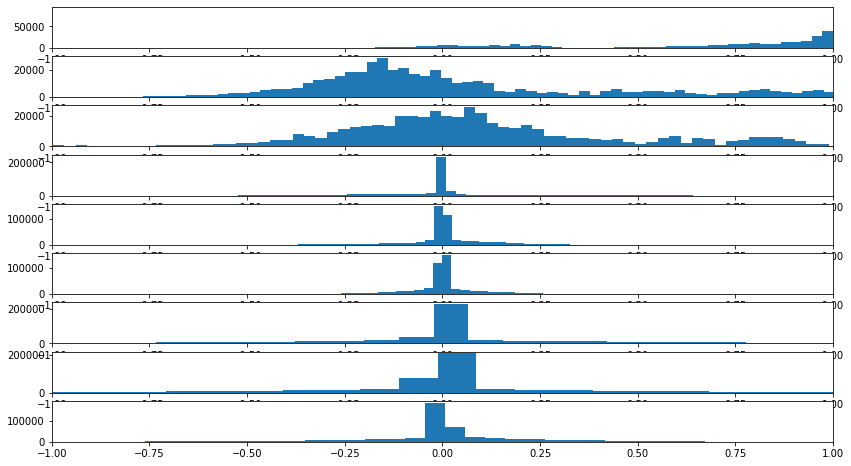

In [18]:
pyplot.figure(figsize=(14, 8))
xaxis = None

for i in range(longX.shape[1]):
    ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
    ax.set_xlim(-1, 1)
    if i == 0:
        xaxis = ax
    pyplot.hist(longX[:, i], bins=100)

pyplot.show()

In [19]:
# The data is sufficiently Gaussian-like to explore whether a standardization transform 
# will help the model extract salient signal from the raw observations.

# try out fitting after the standardization with the same model and compare the results, but our
# main aim was to understand how to develop Conv1D model.

# Let's plot the model 

In [20]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPool1D(pool_size=2))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

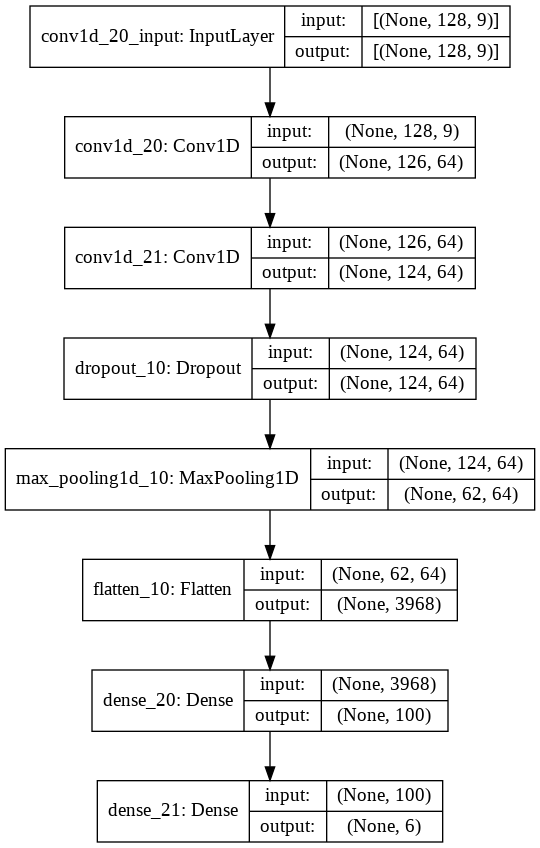

In [23]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes = True, to_file='Conv1D_example.png')

In [ ]:
# Conv1D shape = (None, 126, 64) because 64=number of filters, 126 because timesteps=128 and filter_size = 3
# therefore output shape=128 - 3 + 1=126
